In [1]:
from lib.policy_guided_explorer import Explorer
from lib.implicit_mdp import PTO_wrapper
import pandas

In [2]:
from lib.models.generic_v0.bitcoin import Bitcoin as G0Bitcoin
from lib.models.generic_v0.model import SelfishMining as G0Model
from lib.models.generic_v1.protocols.bitcoin import Protocol as G1Bitcoin
from lib.models.generic_v1.protocols.ghostdag import Protocol as G1Ghostdag
from lib.models.generic_v1.model import SingleAgent as G1Model
from lib.models.aft20barzur import BitcoinSM as AFT20BarZur
from lib.models.fc16sapirshtein import BitcoinSM as FC16Sapirshtein

network = dict(alpha=0.33, gamma=0.33)

models = []
implicit_mdps = []


def add_model(*, implicit_mdp, **model):
    models.append(model)
    implicit_mdps.append(implicit_mdp)


add_model(
    model="aft20barzur",
    force_consider_own=True,
    merge_isomorphic=True,
    protocol="bitcoin",
    implicit_mdp=AFT20BarZur(**network, maximum_fork_length=999999),
)
add_model(
    model="fc16sapirshtein",
    force_consider_own=True,
    merge_isomorphic=True,
    protocol="bitcoin",
    implicit_mdp=FC16Sapirshtein(**network, maximum_fork_length=999999),
)
add_model(
    model="generic_0",
    force_consider_own=False,
    merge_isomorphic=False,
    protocol="bitcoin",
    implicit_mdp=G0Model(
        G0Bitcoin(),
        **network,
        maximum_size=999999,
        force_consider_own=False,
        merge_isomorphic=False
    ),
)
add_model(
    model="generic_0",
    force_consider_own=True,
    merge_isomorphic=False,
    protocol="bitcoin",
    implicit_mdp=G0Model(
        G0Bitcoin(),
        **network,
        maximum_size=999999,
        force_consider_own=True,
        merge_isomorphic=False
    ),
)
add_model(
    model="generic_0",
    force_consider_own=False,
    merge_isomorphic=True,
    protocol="bitcoin",
    implicit_mdp=G0Model(
        G0Bitcoin(),
        **network,
        maximum_size=999999,
        force_consider_own=False,
        merge_isomorphic=True
    ),
)
add_model(
    model="generic_0",
    force_consider_own=True,
    merge_isomorphic=True,
    protocol="bitcoin",
    implicit_mdp=G0Model(
        G0Bitcoin(),
        **network,
        maximum_size=999999,
        force_consider_own=True,
        merge_isomorphic=True
    ),
),
add_model(
    model="generic_1",
    force_consider_own=False,
    merge_isomorphic=False,
    protocol="bitcoin",
    implicit_mdp=G1Model(G1Bitcoin, **network, force_consider_own=False),
)
add_model(
    model="generic_1",
    force_consider_own=False,
    merge_isomorphic=False,
    protocol="ghostdag_3",
    implicit_mdp=G1Model(G1Ghostdag, k=3, **network, force_consider_own=False),
)
add_model(
    model="generic_1",
    force_consider_own=True,
    merge_isomorphic=False,
    protocol="bitcoin",
    implicit_mdp=G1Model(G1Bitcoin, **network, force_consider_own=True),
)
add_model(
    model="generic_1",
    force_consider_own=True,
    merge_isomorphic=False,
    protocol="ghostdag_3",
    implicit_mdp=G1Model(G1Ghostdag, k=3, **network, force_consider_own=True),
)


models = pandas.DataFrame(models)
models

,model,force_consider_own,merge_isomorphic,protocol
0,aft20barzur,True,True,bitcoin
1,fc16sapirshtein,True,True,bitcoin
2,generic_0,False,False,bitcoin
3,generic_0,True,False,bitcoin
4,generic_0,False,True,bitcoin
5,generic_0,True,True,bitcoin
6,generic_1,False,False,bitcoin
7,generic_1,False,False,ghostdag_3
8,generic_1,True,False,bitcoin
9,generic_1,True,False,ghostdag_3


In [3]:
horizon = 30  # paper: 100


def working_df_gen():
    for i, r in models.iterrows():
        m = PTO_wrapper(implicit_mdps[i], horizon=horizon, terminal_state=b"terminal")
        yield dict(
            implicit_mdp=m,
            explorer=Explorer(m, m.honest),
            aborted=False,
            last_distance=-1,
            last_size=-1,
        )


working_df = pandas.DataFrame(working_df_gen())
models.join(working_df)

,model,force_consider_own,merge_isomorphic,protocol,implicit_mdp,explorer,aborted,last_distance,last_size
0,aft20barzur,True,True,bitcoin,<lib.implicit_mdp.PTO_wrapper object at 0x7f91...,<lib.policy_guided_explorer.Explorer object at...,False,-1,-1
1,fc16sapirshtein,True,True,bitcoin,<lib.implicit_mdp.PTO_wrapper object at 0x7f91...,<lib.policy_guided_explorer.Explorer object at...,False,-1,-1
2,generic_0,False,False,bitcoin,<lib.implicit_mdp.PTO_wrapper object at 0x7f91...,<lib.policy_guided_explorer.Explorer object at...,False,-1,-1
3,generic_0,True,False,bitcoin,<lib.implicit_mdp.PTO_wrapper object at 0x7f91...,<lib.policy_guided_explorer.Explorer object at...,False,-1,-1
4,generic_0,False,True,bitcoin,<lib.implicit_mdp.PTO_wrapper object at 0x7f91...,<lib.policy_guided_explorer.Explorer object at...,False,-1,-1
5,generic_0,True,True,bitcoin,<lib.implicit_mdp.PTO_wrapper object at 0x7f91...,<lib.policy_guided_explorer.Explorer object at...,False,-1,-1
6,generic_1,False,False,bitcoin,<lib.implicit_mdp.PTO_wrapper object at 0x7f91...,<lib.policy_guided_explorer.Explorer object at...,False,-1,-1
7,generic_1,False,False,ghostdag_3,<lib.implicit_mdp.PTO_wrapper object at 0x7f91...,<lib.policy_guided_explorer.Explorer object at...,False,-1,-1
8,generic_1,True,False,bitcoin,<lib.implicit_mdp.PTO_wrapper object at 0x7f91...,<lib.policy_guided_explorer.Explorer object at...,False,-1,-1
9,generic_1,True,False,ghostdag_3,<lib.implicit_mdp.PTO_wrapper object at 0x7f91...,<lib.policy_guided_explorer.Explorer object at...,False,-1,-1


In [4]:
def step_gen(max_size):
    while True:
        candidates = working_df.query(f"last_size < {max_size} and not aborted")
        if len(candidates) < 1:
            return
        yield candidates.sort_values("last_size").index[0]


from IPython.display import display, clear_output

max_size = 5000

size_log = []

for idx in step_gen(max_size):
    row = working_df.loc[idx]

    if row.last_distance < 0:
        # first exploration of honest policy
        pass
    else:
        # increase distance by one
        try:
            row.explorer.explore_aside_policy(max_states=max_size)
        except RuntimeError as e:
            if e.args == ("state size limit exceeded",):
                working_df.loc[idx, "aborted"] = True
                continue
            else:
                raise e

    explicit_mdp = row.explorer.mdp()
    distance = row.last_distance + 1
    size = explicit_mdp.n_states

    size_log.append(models.loc[idx].to_dict() | dict(distance=distance, size=size))

    working_df.loc[idx, "last_distance"] = distance
    working_df.loc[idx, "last_size"] = size

    clear_output()
    print("last:")
    print(models.loc[idx])
    display(
        models.join(working_df)[
            list(models.columns) + ["last_distance", "last_size", "aborted"]
        ]
    )

size_log = pandas.DataFrame(size_log)

last:
model                 fc16sapirshtein
force_consider_own               True
merge_isomorphic                 True
protocol                      bitcoin
Name: 1, dtype: object


,model,force_consider_own,merge_isomorphic,protocol,last_distance,last_size,aborted
0,aft20barzur,True,True,bitcoin,61,4869,False
1,fc16sapirshtein,True,True,bitcoin,62,4995,False
2,generic_0,False,False,bitcoin,4,3801,True
3,generic_0,True,False,bitcoin,5,7718,False
4,generic_0,False,True,bitcoin,5,5750,False
5,generic_0,True,True,bitcoin,8,5641,False
6,generic_1,False,False,bitcoin,3,18652,False
7,generic_1,False,False,ghostdag_3,2,3756,True
8,generic_1,True,False,bitcoin,3,8526,False
9,generic_1,True,False,ghostdag_3,3,22290,False


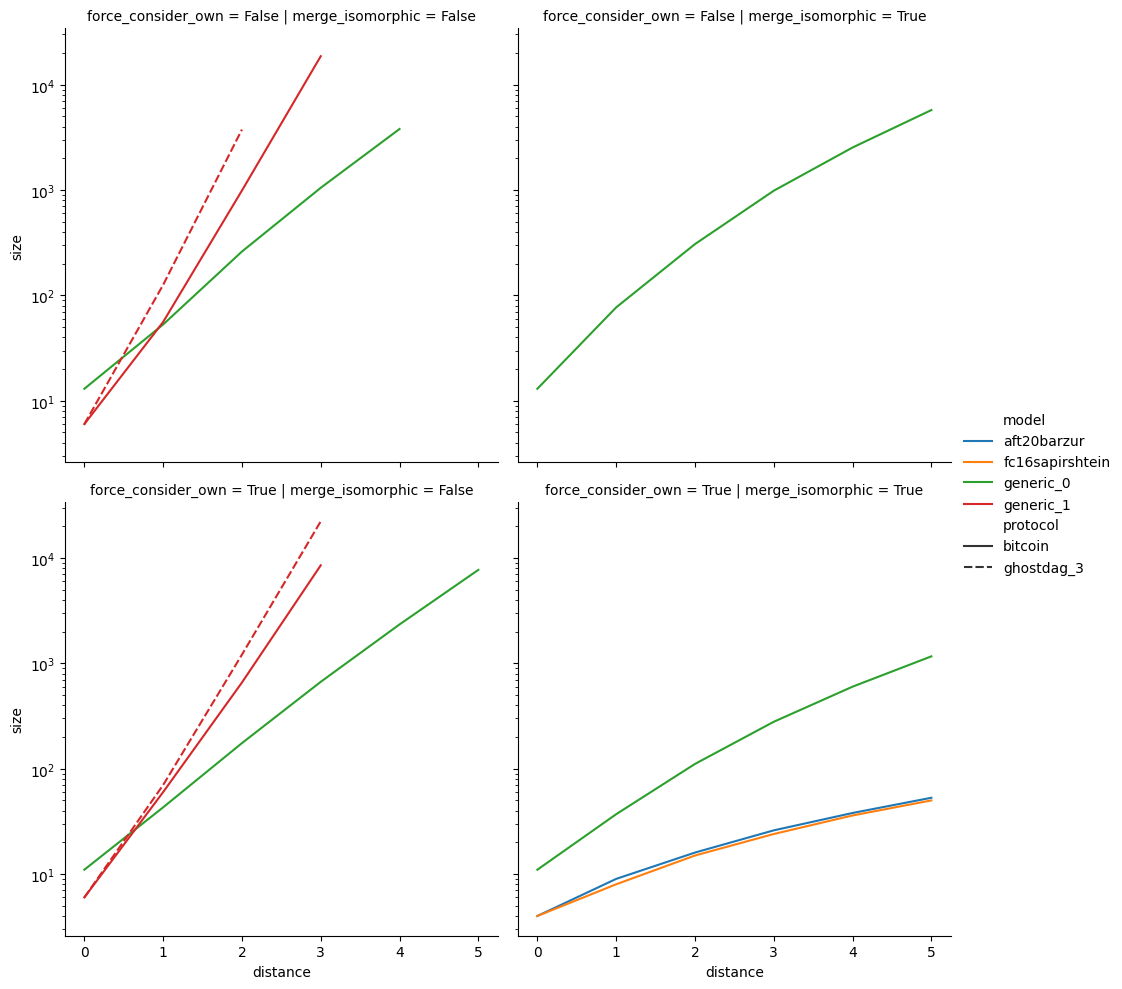

In [5]:
import seaborn

seaborn.relplot(
    data=size_log.query("distance <= 5"),
    kind="line",
    x="distance",
    y="size",
    hue="model",
    style="protocol",
    row="force_consider_own",
    col="merge_isomorphic",
).set(yscale="log")